# Exercise 1: Linear Image Classifier

In this exercise you will implement a linear image classifier while getting familiar with `numpy` and the benefits of vectorized operations in Python. This exercise has 3 parts:

1. Python warmup: working with images, refresher on classes and objects.
2. Implementing loss functions, calculating gradients and implementing gradient descent.
3. Training and evaluating several classifiers.

## Submission guidelines:

Your zip should include the following files only:
```
- HW1.ipynb
- functions/
    - classifier.py
    - losses.py
```
Name the file `ex1_ID.zip` and do **not** include any additional directories or the data. 

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever instructed. 
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Do not change the functions we provided you. 
4. Write your functions in the instructed python modules only. All the logic you write is imported and used using this jupyter notebook. You are allowed to add functions as long as they are located in the python modules and are imported properly.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. Any other imports are forbidden.
6. Your code must run without errors. Use `python 3` and `numpy 1.15.4` (configure a new environment as shown in the 2nd lecture if needed). Changes of the configuration we provided are at your own risk. Before submitting the exercise, restart the kernel and run the notebook from start to finish to make sure everything works. **Code that cannot run will not be tested.**
7. Write your own code. Cheating will not be tolerated. 
8. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support).

Q: What archive file format should you be using to compress the files and upload them to Moodle?

A: *.zip

Q: Should you run your code and make sure everything works just before you **zip** the files for submission? What will happen if your code cannot run?

A: ill fix it

Q: Should you include the data in your submission?

A: no

In [246]:
import os
import numpy as np
import matplotlib.pyplot as plt
from functions.classifier import LinearPerceptron
from functions.classifier import LogisticRegression
from functions.classifier import L2Regression
from functions.losses import perceptron_loss_vectorized
from functions.losses import perceptron_loss_naive
from functions.losses import binary_cross_entropy, l2_loss_vectorized
from functions.losses import grad_check

# specify the way plots behave in jupyter notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [247]:
import platform
print("Python version: ", platform.python_version())
print("Numpy version: ", np.__version__)

Python version:  3.7.1
Numpy version:  1.15.4


## Data preprocessing
The next few cells will download and extract CIFAR-10 into `datasets/cifar10/`. The CIFAR-10 dataset consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. The dataset is divided into five training batches and one test batch, each with 10,000 images. The test batch contains exactly 1,000 randomly-selected images from each class.

We have included several image processing functions. Notice the following in particular: we created an additional validation dataset you need to use for hyperparameter optimization (learning rate and L2 regularization). We subtracted the mean from all the images in order to ignore illumination conditions while keeping the content of the image. Next, we flattened the images from a tensor of shape (32x32x3) to a vector with 3072 features (pixel values) so we would be able to use a simple matrix multiplication. Finally, we concatenated each image vector with an additional feature to account for the bias. This is known as the bias trick. 

Make sure you understand this image processing pipeline before diving into the rest of the code.

In [248]:
from datasets import load_cifar10
URL = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
PATH = 'datasets/cifar10/' # the script will create required directories
load_cifar10.maybe_download_and_extract(URL, PATH)

Data has apparently already been downloaded and unpacked.


In [249]:
CIFAR10_PATH = os.path.join(PATH, 'cifar-10-batches-py')
X_train, y_train, X_test, y_test = load_cifar10.load(CIFAR10_PATH) # load the entire data

# taking only two classes from the dataset
X_train = X_train[np.logical_or(y_train == 0, y_train == 1)]
y_train = y_train[np.logical_or(y_train == 0, y_train == 1)]
X_test = X_test[np.logical_or(y_test == 0, y_test == 1)]
y_test = y_test[np.logical_or(y_test == 0, y_test == 1)]

# define a splitting for the data
num_training = 10000
num_validation = 1000
num_testing = 1000

# add a validation dataset for hyperparameter optimization
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]
mask = range(num_validation)
X_val = X_test[mask]
y_val = y_test[mask]
mask = range(num_validation, num_validation+num_testing)
X_test = X_test[mask]
y_test = y_test[mask]

# float64
X_train = X_train.astype(np.float64)
X_val = X_val.astype(np.float64)
X_test = X_test.astype(np.float64)

# subtract the mean from all the images in the batch
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

# flatten all the images in the batch (make sure you understand why this is needed)
X_train = np.reshape(X_train, newshape=(X_train.shape[0], -1))
X_val = np.reshape(X_val, newshape=(X_val.shape[0], -1)) 
X_test = np.reshape(X_test, newshape=(X_test.shape[0], -1)) 

# add a bias term to all images in the batch
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))]) 
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))]) 
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))]) 

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
classes = ('plane', 'car')

(10000, 3073)
(1000, 3073)
(1000, 3073)


        plane         plane           car           car


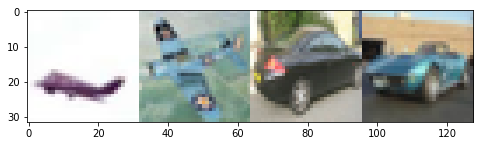

In [250]:
def get_batch(X, y, n):
    rand_items = np.random.randint(0, X.shape[0], size=n)
    images = X[rand_items]
    labels = y[rand_items]
    return X, y

def make_random_grid(x, y, n=4):
    rand_items = np.random.randint(0, x.shape[0], size=n)
    images = x[rand_items]
    labels = y[rand_items]
    grid = np.hstack((np.asarray((vec_2_img(i) + mean_image), dtype=np.int) for i in images))
    print(' '.join('%13s' % classes[labels[j]] for j in range(4)))
    return grid

def vec_2_img(x):
    x = np.reshape(x[:-1], (32, 32, 3))
    return x

X_batch, y_batch = get_batch(X_test, y_test, 4)
plt.imshow(make_random_grid(X_batch, y_batch));

## Linear classifier: mapping images to scores

During this exercise, we will maintain a python class with basic functionality (such as training the model). the linear classifiers we will build (perceptron, logistic regression) will inherit some functionality from that class and will change several functions (such as the loss function, for example). Open the file `functions/classifier.py` and make sure you understand the code. You might find this [short classes in python tutorial](https://www.hackerearth.com/practice/python/object-oriented-programming/classes-and-objects-i/tutorial/) useful.

## Linear perceptron
Our first linear classifier will include a linear function that maps images to scores:

$$
f(x_i; W, b) = W\cdot x_i + b
$$

As you learned in class, this linear classifier takes an input image $x_i$ and outputs a class score. Your goal is to **learn** the parameters $W$ and $b$ to best classify the images according to the provided labels. The linear perceptron is set up so that the perceptron learn to map the correct class for each image such that it will have a score higher than the incorrect class. In this exercise, we will define our Linear perceptron to have two outputs - one outputs for each class.      

Open the file `functions/classifier.py`. The constructor of the `LinearPerceptron` class takes as input the dataset and labels in order to create appropriate parameters. Notice we are using the bias trick and only use the matrix `w` for convenience. Since we already have a (random) model, we can start predicting classes on images. Complete the method `predict` in the `LinearPerceptron` class. **(2.5 points)**

In [251]:
classifier = LinearPerceptron(X_train, y_train)
y_pred = classifier.predict(X_test)

        plane         plane         plane         plane


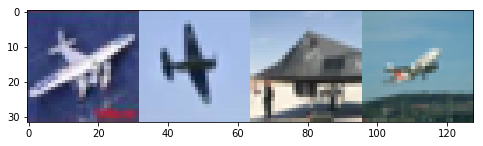

In [252]:
X_batch, y_batch = get_batch(X_train, y_train, 4)
plt.imshow(make_random_grid(X_batch, y_batch));

In [106]:
# predictions
print(' '.join('%13s' % classes[y_pred[j]] for j in range(4)))

          car           car         plane         plane


## Evaluation

Complete the class method `calc_accuracy` in `functions/classifier.py`. Explain why the accuracy on the training dataset (remember, the model is not trained yet) is around 50%. **(2.5 points)**

In [107]:
print("model accuracy: ", classifier.calc_accuracy(X_train, y_train))

model accuracy:  46.06


Your answer here: Because the model is not trained, we predict using the inital weights, which were init to all zeros, hence we will allways return the same prediction. which will fit the same class.
As we can see in the code provided in the notebook, we are predicting against 2 class with sample distribution of 50%
Our predict will always yeild the same answer (in our case plane) and we will have 50% accurecy rate (:

## Hinge loss (30 points)

Your code for this section will all be written inside `functions/losses.py`. In this section, we write and test code outside the classes for convenience. Notice the loss method for each class is just a call for the loss function written in `losses.py`. Once you are finished with implementation, everything should work.

First, complete the function `perceptron_loss_naive`. This function takes as input the weights, data, labels and a regularization term and outputs the calculated loss as a single number and the gradients with respect to W.

In [108]:
W = np.random.randn(3073, 2) * 0.0001

In [109]:
%%time
loss_naive, grad_naive = perceptron_loss_naive(W, X_val, y_val)
print ('loss: %f' % (loss_naive, ))
print ('grad_naive: {}'.format(grad_naive))

loss: 1.146865
grad_naive: [[-6.59484960e+00  6.59484960e+00]
 [-1.57147872e+01  1.57147872e+01]
 [-2.51987936e+01  2.51987936e+01]
 ...
 [-7.90779200e+00  7.90779200e+00]
 [-1.06642672e+01  1.06642672e+01]
 [ 1.60000000e-02 -1.60000000e-02]]
CPU times: user 100 ms, sys: 1.8 ms, total: 102 ms
Wall time: 52.9 ms


You are provided with a gradient checking function called `grad_check` in `functions/losses.py`. The following cells test your implementation of the loss value and gradient. Errors should be below $10^{-8}$.

In [110]:
loss, grad = perceptron_loss_naive(W, X_val, y_val)
f = lambda w: perceptron_loss_naive(w, X_val, y_val)[0]
grad_numerical = grad_check(f, W, grad)

numerical: -9.493371 analytic: -9.493371, relative error: 6.987828e-13
numerical: 8.986376 analytic: 8.986376, relative error: 3.226307e-12
numerical: -4.811381 analytic: -4.811381, relative error: 7.486432e-13
numerical: -0.091326 analytic: -0.091326, relative error: 1.105222e-10
numerical: -9.255227 analytic: -9.255227, relative error: 2.389914e-12
numerical: 9.572347 analytic: 9.572347, relative error: 2.678913e-12
numerical: 28.470085 analytic: 28.470085, relative error: 1.422579e-13
numerical: -19.306160 analytic: -19.306160, relative error: 1.179198e-12
numerical: 18.460011 analytic: 18.460011, relative error: 1.953318e-12
numerical: -25.714869 analytic: -25.714869, relative error: 5.993292e-13


Once your code works, complete the function `perceptron_loss_vectorized` and compare the results of the two functions using the cell below.

In [111]:
%%time

loss_vectorized, grad_vectorized = perceptron_loss_vectorized(W, X_val, y_val)
print ('loss: %f' % (loss, ))

difference = np.linalg.norm(grad_naive - grad_vectorized)
print ('difference: %f' % difference)

correct_score.shape  - (1000,)
loss: 1.146865
difference: 0.000000
CPU times: user 13.2 ms, sys: 1.81 ms, total: 15 ms
Wall time: 10 ms


We have obtained an efficient function for loss and gradient calculation and we can now train our network. Complete the function `train` in `functions/classifier.py`. This function should be implemented in the `LinearClassifier` class. (**10 points**)

In [272]:
%%time
perceptron = LinearPerceptron(X_train, y_train)
loss_history = perceptron.train(X_train, y_train, 
                         learning_rate=1e-7,
                         num_iters=1500,
                         verbose=True)

loss = 0.9530422002557737
grad shape = (3073, 2)
W shape = (3073, 2)
iteration 0 / 1500: loss 0.953042
loss = 0.8472761411858533
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.7726543517088679
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.7540189238917742
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.64573684570431
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.7364040743361379
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.5802269962534953
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.6524410459274438
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.6248770132593569
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.6879706822012163
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.6154425592377252
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.6316911121712983
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.6879173361377983
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.6202341823254484
grad shape = (3073, 2)
W shape = (3073, 2)
lo

loss = 0.48433992353624494
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4556393128750253
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4533111391504265
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.5156928630768571
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4713671710117018
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.51169908192112
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.44795450524589325
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4207025784380184
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4007786553316101
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.49576452068738897
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4946983141485887
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.5078909522972045
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4344634496742955
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4887258948324764
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4859831691471801
grad sh

loss = 0.4806518260129202
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4272645340951628
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.43874670903299495
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.3693586429212276
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.3945436312018157
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.42182661862834836
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4744872854985063
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.48098654958219456
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.5914364469946204
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.480926505723587
grad shape = (3073, 2)
W shape = (3073, 2)
iteration 300 / 1500: loss 0.480927
loss = 0.39001948925652813
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4226313416207358
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.5273682704746006
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.5234387565923023
grad shape = (3073, 2)
W shape = (3073

loss = 0.4354017320349245
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4132741159636099
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4375232336489705
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.5412601057318591
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.47092604937825727
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.3881264145458863
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.43446964206917377
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.40640182785184903
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.45156769819502357
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.47923501953587916
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.5165609914001249
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.5235548328155482
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.44620515154773444
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.5131293897485861
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.5074473226939051
gr

loss = 0.42671475770414496
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.40120478210861843
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4042288406840682
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4607903406965438
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.503249718321109
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.507672322601119
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.44881778796947785
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4661144293796179
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4456620710830424
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.5199851086383298
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.3677315594217916
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4499013709613882
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.41021337713322564
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.41861912670816304
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.43006454668537003
grad

loss = 0.4622076700530871
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4620026378758063
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4830408983491289
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.454819701100752
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.506909020879014
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4514362289291584
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4553228333590802
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.39921962745371536
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.34117877122549445
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4550551173422003
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4370010533745862
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4089597953832255
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.39384406992785354
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.5242502635544095
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.39190524398985116
grad s

loss = 0.4905996595746486
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.44944767649827966
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4008100682964589
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.43460790181385844
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.5114569501930244
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4455012350612679
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.48074320262904974
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.39888424666213157
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4206781344085356
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4369205605909403
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4226142267102684
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4137458202732694
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.42693424435999205
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.48308345416089177
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4768640240085203
gr

loss = 0.4454380846061302
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.38801034497334486
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4599799483251805
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.36432868923669387
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4048991786528178
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.3592604971962935
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.38382096871338434
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4333446966139433
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.42776449077153017
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.44113229468248905
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.38845029592676894
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.38427974209371385
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.2993682772053316
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4499028242339517
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.42891447835192426


loss = 0.4762920754870548
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.40864659004478043
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4851295352581692
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.3647761044543265
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.3970397988396875
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.37291883821085703
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.3035313526195337
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.41959056199165856
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.3601648788302917
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4298552875461833
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.5090659617445918
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.3872890797585371
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.39877872031881784
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.38157311688511486
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4158751844854316
gra

loss = 0.43373554415953686
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.40196426373431493
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4687995569045846
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4465673993151885
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.36046135895656606
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4582577483655919
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.48429222559122714
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.42249959681894594
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4720595281055479
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4464787054762037
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.3460332833527271
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4242698909725893
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.45206259925936637
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.5001985045076791
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.45224204912686133
g

loss = 0.3879821900377361
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4643491619012867
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.49553725432637086
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.36687340001879987
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.3712004119031401
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.39435198759141765
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.48442099890580964
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.3727217229052644
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.34860296930332607
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4476759950147595
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.40634839510934584
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.4684836641568465
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.3778951040339896
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.5247310748526303
grad shape = (3073, 2)
W shape = (3073, 2)
loss = 0.46097205909028605
g

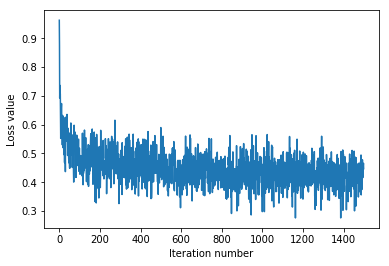

In [113]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [114]:
print("Training accuracy: ", perceptron.calc_accuracy(X_train, y_train))
print("Testing accuracy: ", perceptron.calc_accuracy(X_test, y_test))

Training accuracy:  83.0
Testing accuracy:  82.89999999999999


## Hyperparameter optimization

Your model should have improved from 50% accuracy to ~75% accuracy in a matter of seconds. Now, use the validation set to tune hyperparameters by training different models (using the training dataset) and evaluating the performance using the validation dataset. Save the results in a dictionary mapping tuples of the form `(learning_rate, batch_size)` to tuples of the form `(training_accuracy, validation_accuracy)`. Finally, you should evaluate the best model on the testing dataset. 

Note: When changing the batch_size, change the number of iterations accordingly such that the number of epochs on the data stays roughly the same. A reasonable ratio is 600 iterations for a batch size of 200. 

If you are carful you should reach ~83% accuracy on the validation dataset.

Use a small value for the number of iterations as you develop your code. Once you are confident that everything works, run it again for more iterations. Finally, explain the results - what can you learn from the hyper parameters that yields the best results? Why do you think that is the case? **(5 points)**

In [40]:
# You are encouraged to experiment with additional values
learning_rates = [1e-7, 5e-6]
batch_sizes = [1, 100, 200, 500, 10000]

results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_perceptron = None # The LinearPerceptron object that achieved the highest validation rate.

################################################################################
#                            START OF YOUR CODE                                #
################################################################################
num_of_samples = X_train.shape[0]
print(num_of_samples)
epochs = 200*600/num_of_samples
print(epochs)

for lr in learning_rates:
    for bs in batch_sizes:
        num_iters = int(epochs*num_of_samples/bs)
        print(num_iters)
        p = LinearPerceptron(X_train, y_train)
        _ = p.train(X_train, y_train, learning_rate=lr, num_iters=num_iters,batch_size=bs,verbose=True)
        val_accuracy = p.calc_accuracy(X_val, y_val)
        train_accuracy = p.calc_accuracy(X_train, y_train)
        
#         print('(lr, bs) = {}'.format((lr, bs)))
#         print('(val_accuracy,train_accuracy, best_val) = {}'.format((val_accuracy, train_accuracy, best_val)))

        if val_accuracy > best_val:
            best_val = val_accuracy
            best_perceptron = p
        results[(lr, bs)] = (train_accuracy,val_accuracy)

################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, batch_size in sorted(results):
    train_accuracy, val_accuracy = results[(lr, batch_size)]
    print ('lr %e batch_size %e train accuracy: %f val accuracy: %f' % (
                lr, batch_size, train_accuracy, val_accuracy))
    
print ('best validation accuracy achieved during cross-validation: %f' % best_val)

test_accuracy = best_perceptron.calc_accuracy(X_test, y_test)
print ('linear perceptron on raw pixels final test set accuracy: %f' % test_accuracy)

10000
12.0
120000
iteration 0 / 120000: loss 1.251531
iteration 100 / 120000: loss 0.000000
iteration 200 / 120000: loss 0.000000
iteration 300 / 120000: loss 0.000000
iteration 400 / 120000: loss 0.000000
iteration 500 / 120000: loss 0.000000
iteration 600 / 120000: loss 0.000000
iteration 700 / 120000: loss 0.178634
iteration 800 / 120000: loss 0.453996
iteration 900 / 120000: loss 0.000000
iteration 1000 / 120000: loss 0.000000
iteration 1100 / 120000: loss 0.426438
iteration 1200 / 120000: loss 2.395089
iteration 1300 / 120000: loss 0.000000
iteration 1400 / 120000: loss 0.000000
iteration 1500 / 120000: loss 0.000000
iteration 1600 / 120000: loss 0.000000
iteration 1700 / 120000: loss 1.643363
iteration 1800 / 120000: loss 0.000000
iteration 1900 / 120000: loss 0.000000
iteration 2000 / 120000: loss 0.000000
iteration 2100 / 120000: loss 0.000000
iteration 2200 / 120000: loss 0.000000
iteration 2300 / 120000: loss 0.000000
iteration 2400 / 120000: loss 0.965308
iteration 2500 / 12

iteration 21100 / 120000: loss 1.276345
iteration 21200 / 120000: loss 0.859091
iteration 21300 / 120000: loss 0.000000
iteration 21400 / 120000: loss 0.000000
iteration 21500 / 120000: loss 0.000000
iteration 21600 / 120000: loss 0.000000
iteration 21700 / 120000: loss 0.000000
iteration 21800 / 120000: loss 0.000000
iteration 21900 / 120000: loss 0.000000
iteration 22000 / 120000: loss 0.000000
iteration 22100 / 120000: loss 0.000000
iteration 22200 / 120000: loss 2.510809
iteration 22300 / 120000: loss 0.000000
iteration 22400 / 120000: loss 0.000000
iteration 22500 / 120000: loss 3.535864
iteration 22600 / 120000: loss 0.000000
iteration 22700 / 120000: loss 0.020565
iteration 22800 / 120000: loss 0.000000
iteration 22900 / 120000: loss 3.990159
iteration 23000 / 120000: loss 0.000000
iteration 23100 / 120000: loss 0.000000
iteration 23200 / 120000: loss 0.000000
iteration 23300 / 120000: loss 0.000000
iteration 23400 / 120000: loss 0.000000
iteration 23500 / 120000: loss 0.000000


iteration 42400 / 120000: loss 0.910735
iteration 42500 / 120000: loss 0.000000
iteration 42600 / 120000: loss 0.215614
iteration 42700 / 120000: loss 0.000000
iteration 42800 / 120000: loss 0.000000
iteration 42900 / 120000: loss 2.711380
iteration 43000 / 120000: loss 0.000000
iteration 43100 / 120000: loss 9.801530
iteration 43200 / 120000: loss 0.000000
iteration 43300 / 120000: loss 0.308891
iteration 43400 / 120000: loss 0.000000
iteration 43500 / 120000: loss 0.594299
iteration 43600 / 120000: loss 0.000000
iteration 43700 / 120000: loss 0.000000
iteration 43800 / 120000: loss 0.000000
iteration 43900 / 120000: loss 0.000000
iteration 44000 / 120000: loss 0.000000
iteration 44100 / 120000: loss 0.000000
iteration 44200 / 120000: loss 0.000000
iteration 44300 / 120000: loss 2.561618
iteration 44400 / 120000: loss 5.837594
iteration 44500 / 120000: loss 0.000000
iteration 44600 / 120000: loss 3.277262
iteration 44700 / 120000: loss 5.585256
iteration 44800 / 120000: loss 0.643821


iteration 63500 / 120000: loss 0.000000
iteration 63600 / 120000: loss 0.000000
iteration 63700 / 120000: loss 0.000000
iteration 63800 / 120000: loss 0.000000
iteration 63900 / 120000: loss 1.303732
iteration 64000 / 120000: loss 1.067274
iteration 64100 / 120000: loss 1.356230
iteration 64200 / 120000: loss 0.000000
iteration 64300 / 120000: loss 0.000000
iteration 64400 / 120000: loss 2.359722
iteration 64500 / 120000: loss 0.000000
iteration 64600 / 120000: loss 0.000000
iteration 64700 / 120000: loss 2.771687
iteration 64800 / 120000: loss 0.000000
iteration 64900 / 120000: loss 0.000000
iteration 65000 / 120000: loss 0.000000
iteration 65100 / 120000: loss 3.065511
iteration 65200 / 120000: loss 0.000000
iteration 65300 / 120000: loss 4.285764
iteration 65400 / 120000: loss 0.000000
iteration 65500 / 120000: loss 0.000000
iteration 65600 / 120000: loss 0.000000
iteration 65700 / 120000: loss 0.000000
iteration 65800 / 120000: loss 4.677258
iteration 65900 / 120000: loss 0.000000


iteration 84200 / 120000: loss 0.000000
iteration 84300 / 120000: loss 3.259392
iteration 84400 / 120000: loss 0.000000
iteration 84500 / 120000: loss 0.000000
iteration 84600 / 120000: loss 0.000000
iteration 84700 / 120000: loss 0.855697
iteration 84800 / 120000: loss 1.629564
iteration 84900 / 120000: loss 0.000000
iteration 85000 / 120000: loss 0.000000
iteration 85100 / 120000: loss 0.000000
iteration 85200 / 120000: loss 0.000000
iteration 85300 / 120000: loss 0.000000
iteration 85400 / 120000: loss 0.386431
iteration 85500 / 120000: loss 0.000000
iteration 85600 / 120000: loss 0.000000
iteration 85700 / 120000: loss 0.000000
iteration 85800 / 120000: loss 0.365423
iteration 85900 / 120000: loss 0.084671
iteration 86000 / 120000: loss 8.384013
iteration 86100 / 120000: loss 0.000000
iteration 86200 / 120000: loss 0.000000
iteration 86300 / 120000: loss 0.000000
iteration 86400 / 120000: loss 0.000000
iteration 86500 / 120000: loss 0.000000
iteration 86600 / 120000: loss 0.000000


iteration 105200 / 120000: loss 0.000000
iteration 105300 / 120000: loss 0.000000
iteration 105400 / 120000: loss 4.004326
iteration 105500 / 120000: loss 0.000000
iteration 105600 / 120000: loss 0.000000
iteration 105700 / 120000: loss 0.000000
iteration 105800 / 120000: loss 1.629108
iteration 105900 / 120000: loss 0.000000
iteration 106000 / 120000: loss 0.000000
iteration 106100 / 120000: loss 0.000000
iteration 106200 / 120000: loss 3.387469
iteration 106300 / 120000: loss 0.000000
iteration 106400 / 120000: loss 0.000000
iteration 106500 / 120000: loss 0.000000
iteration 106600 / 120000: loss 1.871738
iteration 106700 / 120000: loss 0.000000
iteration 106800 / 120000: loss 0.000000
iteration 106900 / 120000: loss 0.000000
iteration 107000 / 120000: loss 0.000000
iteration 107100 / 120000: loss 0.000000
iteration 107200 / 120000: loss 0.000000
iteration 107300 / 120000: loss 0.000000
iteration 107400 / 120000: loss 0.601300
iteration 107500 / 120000: loss 3.270594
iteration 107600

iteration 3900 / 120000: loss 0.000000
iteration 4000 / 120000: loss 0.000000
iteration 4100 / 120000: loss 9.085795
iteration 4200 / 120000: loss 0.000000
iteration 4300 / 120000: loss 0.000000
iteration 4400 / 120000: loss 0.000000
iteration 4500 / 120000: loss 108.325167
iteration 4600 / 120000: loss 43.585671
iteration 4700 / 120000: loss 0.000000
iteration 4800 / 120000: loss 0.000000
iteration 4900 / 120000: loss 88.115153
iteration 5000 / 120000: loss 0.000000
iteration 5100 / 120000: loss 100.508860
iteration 5200 / 120000: loss 0.000000
iteration 5300 / 120000: loss 129.015493
iteration 5400 / 120000: loss 0.000000
iteration 5500 / 120000: loss 0.000000
iteration 5600 / 120000: loss 0.000000
iteration 5700 / 120000: loss 0.000000
iteration 5800 / 120000: loss 0.000000
iteration 5900 / 120000: loss 0.000000
iteration 6000 / 120000: loss 0.000000
iteration 6100 / 120000: loss 0.000000
iteration 6200 / 120000: loss 0.000000
iteration 6300 / 120000: loss 0.000000
iteration 6400 / 

iteration 24700 / 120000: loss 0.000000
iteration 24800 / 120000: loss 0.000000
iteration 24900 / 120000: loss 0.000000
iteration 25000 / 120000: loss 0.000000
iteration 25100 / 120000: loss 0.000000
iteration 25200 / 120000: loss 0.000000
iteration 25300 / 120000: loss 0.000000
iteration 25400 / 120000: loss 0.000000
iteration 25500 / 120000: loss 0.000000
iteration 25600 / 120000: loss 0.000000
iteration 25700 / 120000: loss 0.000000
iteration 25800 / 120000: loss 0.000000
iteration 25900 / 120000: loss 0.000000
iteration 26000 / 120000: loss 0.000000
iteration 26100 / 120000: loss 0.000000
iteration 26200 / 120000: loss 0.000000
iteration 26300 / 120000: loss 0.000000
iteration 26400 / 120000: loss 0.000000
iteration 26500 / 120000: loss 17.219070
iteration 26600 / 120000: loss 0.000000
iteration 26700 / 120000: loss 0.000000
iteration 26800 / 120000: loss 63.469840
iteration 26900 / 120000: loss 0.000000
iteration 27000 / 120000: loss 0.000000
iteration 27100 / 120000: loss 81.2889

iteration 45100 / 120000: loss 0.000000
iteration 45200 / 120000: loss 0.000000
iteration 45300 / 120000: loss 0.000000
iteration 45400 / 120000: loss 0.000000
iteration 45500 / 120000: loss 0.000000
iteration 45600 / 120000: loss 0.000000
iteration 45700 / 120000: loss 0.000000
iteration 45800 / 120000: loss 0.000000
iteration 45900 / 120000: loss 0.000000
iteration 46000 / 120000: loss 0.000000
iteration 46100 / 120000: loss 0.000000
iteration 46200 / 120000: loss 0.000000
iteration 46300 / 120000: loss 0.000000
iteration 46400 / 120000: loss 0.000000
iteration 46500 / 120000: loss 4.465153
iteration 46600 / 120000: loss 0.000000
iteration 46700 / 120000: loss 0.000000
iteration 46800 / 120000: loss 0.000000
iteration 46900 / 120000: loss 9.509631
iteration 47000 / 120000: loss 0.000000
iteration 47100 / 120000: loss 0.000000
iteration 47200 / 120000: loss 0.000000
iteration 47300 / 120000: loss 22.303325
iteration 47400 / 120000: loss 0.000000
iteration 47500 / 120000: loss 0.000000

iteration 65500 / 120000: loss 0.000000
iteration 65600 / 120000: loss 0.000000
iteration 65700 / 120000: loss 0.000000
iteration 65800 / 120000: loss 0.000000
iteration 65900 / 120000: loss 29.669881
iteration 66000 / 120000: loss 0.000000
iteration 66100 / 120000: loss 32.791994
iteration 66200 / 120000: loss 0.000000
iteration 66300 / 120000: loss 311.971327
iteration 66400 / 120000: loss 56.206257
iteration 66500 / 120000: loss 0.000000
iteration 66600 / 120000: loss 0.000000
iteration 66700 / 120000: loss 0.000000
iteration 66800 / 120000: loss 0.000000
iteration 66900 / 120000: loss 0.000000
iteration 67000 / 120000: loss 12.022982
iteration 67100 / 120000: loss 0.000000
iteration 67200 / 120000: loss 43.314906
iteration 67300 / 120000: loss 0.000000
iteration 67400 / 120000: loss 0.000000
iteration 67500 / 120000: loss 0.000000
iteration 67600 / 120000: loss 0.000000
iteration 67700 / 120000: loss 0.000000
iteration 67800 / 120000: loss 0.000000
iteration 67900 / 120000: loss 27

iteration 86600 / 120000: loss 0.000000
iteration 86700 / 120000: loss 0.000000
iteration 86800 / 120000: loss 0.000000
iteration 86900 / 120000: loss 170.528059
iteration 87000 / 120000: loss 0.000000
iteration 87100 / 120000: loss 53.166335
iteration 87200 / 120000: loss 16.312487
iteration 87300 / 120000: loss 24.899325
iteration 87400 / 120000: loss 0.000000
iteration 87500 / 120000: loss 0.000000
iteration 87600 / 120000: loss 121.490739
iteration 87700 / 120000: loss 0.000000
iteration 87800 / 120000: loss 0.000000
iteration 87900 / 120000: loss 0.000000
iteration 88000 / 120000: loss 0.000000
iteration 88100 / 120000: loss 0.000000
iteration 88200 / 120000: loss 5.467364
iteration 88300 / 120000: loss 0.000000
iteration 88400 / 120000: loss 0.000000
iteration 88500 / 120000: loss 0.000000
iteration 88600 / 120000: loss 0.000000
iteration 88700 / 120000: loss 0.000000
iteration 88800 / 120000: loss 0.000000
iteration 88900 / 120000: loss 0.000000
iteration 89000 / 120000: loss 0.

iteration 107900 / 120000: loss 34.024418
iteration 108000 / 120000: loss 0.000000
iteration 108100 / 120000: loss 0.000000
iteration 108200 / 120000: loss 0.000000
iteration 108300 / 120000: loss 0.000000
iteration 108400 / 120000: loss 0.000000
iteration 108500 / 120000: loss 0.000000
iteration 108600 / 120000: loss 0.000000
iteration 108700 / 120000: loss 0.000000
iteration 108800 / 120000: loss 0.000000
iteration 108900 / 120000: loss 34.617998
iteration 109000 / 120000: loss 0.000000
iteration 109100 / 120000: loss 0.000000
iteration 109200 / 120000: loss 0.000000
iteration 109300 / 120000: loss 0.000000
iteration 109400 / 120000: loss 0.000000
iteration 109500 / 120000: loss 0.000000
iteration 109600 / 120000: loss 102.986515
iteration 109700 / 120000: loss 17.533293
iteration 109800 / 120000: loss 0.000000
iteration 109900 / 120000: loss 54.656800
iteration 110000 / 120000: loss 0.000000
iteration 110100 / 120000: loss 0.000000
iteration 110200 / 120000: loss 0.000000
iteration 

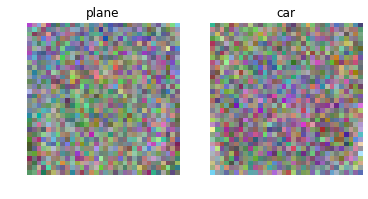

In [41]:
w = best_perceptron.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 2)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car']
for i in range(2):
    plt.subplot(1, 2, i + 1)
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

## Logistic regression

Another choice for a binary classifier is the binary logistic regression classifier. Unlike the perceptron which treats the outputs as uncalibrated and possibly difficult to interpret scores for each class, the binary logistic regression classifier gives a slightly more intuitive output in the form of normalized class probabilities. In this classifier, the function mapping $f(x_i; W, b) = W\cdot x_i + b$ stays unchanged but we now interpret these scores as the unnormalized log probabilities for each class and replace the hinge loss with a cross-entropy loss. In this exercise, we will define our binary logistic regression classifier to have one input.       

Open the file `functions/classifier.py`. The constructor of the `LogisticRegression` class takes as input the dataset and labels in order to create appropriate parameters. Notice we are using the bias trick and only use the matrix `w` for convenience. Since we already have a (random) model, we can start predicting classes on images. Complete the method `predict` in the `LogisticRegression` class - remember you need to implement the sigmoid function before you can obtain predictions using your classifier. (**2.5 points**)

**Important note**: values passed to the `sigmoid` function can be arbitrarily large or small. When we take the exponent of such values, we might encounter extreme values that might *overflow*. This is known as numerical instability and you should always take care when you use exponent in your functions. 

In [223]:
logistic = LogisticRegression(X_train, y_train)
y_pred = logistic.predict(X_test)

y_pred.shape = (1000,)


          car         plane         plane         plane


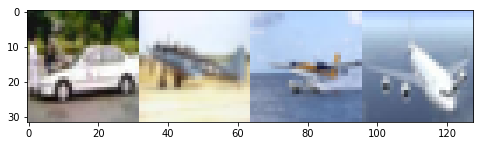

In [224]:
X_batch, y_batch = get_batch(X_train, y_train, 4)
plt.imshow(make_random_grid(X_batch, y_batch));

In [225]:
# predictions
print(' '.join('%13s' % classes[y_pred[j]] for j in range(4)))

          car           car           car         plane


## Evaluation

Complete the class method `calc_accuracy` in the `LinearClassifier` located in `functions/classifier.py`. (**2.5 points**)

In [226]:
print("model accuracy: ", logistic.calc_accuracy(X_train, y_train))

y_pred.shape = (10000,)
model accuracy:  53.949999999999996


## Binary cross-entropy (30 points)

Your code for this section will all be written inside **functions/losses.py**. 

Complete the function `binary_cross_entropy` using vectorized code. This function takes as input the weights, data, labels and a regularization term and outputs the calculated loss as a single number and the gradients with respect to W. (**10 points**)

In [227]:
W = np.random.randn(3073, 1) * 0.0001

In [228]:
%%time
loss_naive, grad_naive = binary_cross_entropy(W, X_val, y_val)
print ('loss: %f' % (loss_naive, ))
print ('grad_naive: {}'.format(grad_naive))

loss: 704.897173
grad_naive: [[2605.48422584]
 [5201.99230295]
 [7539.63234927]
 ...
 [2230.49663436]
 [2455.46931263]
 [-255.7718642 ]]
CPU times: user 11.7 ms, sys: 1.6 ms, total: 13.3 ms
Wall time: 6.61 ms


In [229]:
loss, grad = binary_cross_entropy(W, X_val, y_val)
f = lambda w: binary_cross_entropy(w, X_val, y_val)[0]
grad_numerical = grad_check(f, W, grad)

numerical: 6448.146065 analytic: 6448.146111, relative error: 3.588375e-09
numerical: 3276.039869 analytic: 3276.039881, relative error: 1.809704e-09
numerical: 4660.811624 analytic: 4660.811690, relative error: 7.103356e-09
numerical: 3059.310032 analytic: 3059.310104, relative error: 1.179870e-08
numerical: 3673.068278 analytic: 3673.068324, relative error: 6.283229e-09
numerical: 5665.544843 analytic: 5665.544888, relative error: 3.988331e-09
numerical: 3565.553724 analytic: 3565.553773, relative error: 6.952019e-09
numerical: 3277.094014 analytic: 3277.094080, relative error: 1.016593e-08
numerical: 3722.333974 analytic: 3722.334043, relative error: 9.377157e-09
numerical: 3344.259992 analytic: 3344.259977, relative error: 2.297682e-09


If implemented correctly, the training procedure you already implemented should work.

In [230]:
%%time
logistic = LogisticRegression(X_train, y_train)
loss_history = logistic.train(X_train, y_train, 
                         learning_rate=1e-7,
                         num_iters=1500,
                         verbose=True)

iteration 0 / 1500: loss 142.609334
iteration 100 / 1500: loss 111.797106
iteration 200 / 1500: loss 105.747247
iteration 300 / 1500: loss 140.842512
iteration 400 / 1500: loss 110.295055
iteration 500 / 1500: loss 93.996205
iteration 600 / 1500: loss 96.283731
iteration 700 / 1500: loss 99.148217
iteration 800 / 1500: loss 127.476556
iteration 900 / 1500: loss 118.561670
iteration 1000 / 1500: loss 119.209318
iteration 1100 / 1500: loss 111.295782
iteration 1200 / 1500: loss 225.897624
iteration 1300 / 1500: loss 139.404622
iteration 1400 / 1500: loss 124.928102
CPU times: user 5.73 s, sys: 40.9 ms, total: 5.77 s
Wall time: 2.93 s


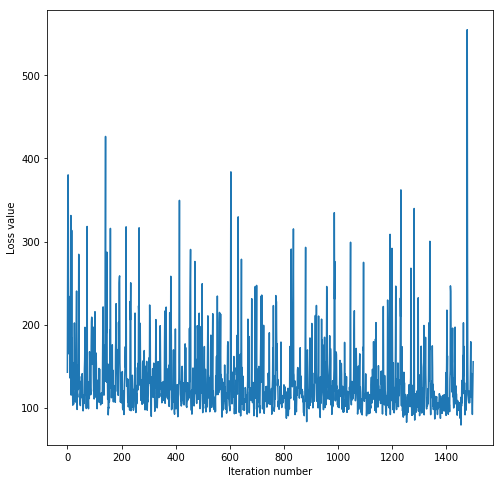

In [231]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [232]:
print("Training accuracy: ", logistic.calc_accuracy(X_train, y_train))
print("Testing accuracy: ", logistic.calc_accuracy(X_test, y_test))

y_pred.shape = (10000,)
Training accuracy:  76.52
y_pred.shape = (1000,)
Testing accuracy:  77.7


## Hyperparameter optimization

Your model should have improved from 50% accuracy to ~75% accuracy in a matter of seconds. Now, use the validation set to tune hyperparameters by training different models (using the training dataset) and evaluating the performance using the validation dataset. Save the results in a dictionary mapping tuples of the form `(learning_rate, batch_size)` to tuples of the form `(training_accuracy, validation_accuracy)`. Finally, you should evaluate the best model on the testing dataset. 

Note: When changing the batch_size, change the number of iterations accordingly such that the number of epochs on the data stays roughly the same. A reasonable ratio is 600 iterations for a batch size of 200. 

If you are carful you should reach ~83% accuracy on the validation dataset.

Use a small value for the number of iterations as you develop your code. Once you are confident that everything works, run it again for more iterations. Finally, explain the results - what can you learn from the hyper parameters that yields the best results? Why do you think that is the case? **(5 points)**

In [233]:
# You are encouraged to experiment with additional values
learning_rates = [1e-7, 5e-6]
batch_sizes = [1, 100, 200, 500, 1000, 10000]

results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_logistic = None # The LogisticRegression object that achieved the highest validation rate.

################################################################################
#                            START OF YOUR CODE                                #
################################################################################
num_of_samples = X_train.shape[0]
print(num_of_samples)
epochs = 200*600/num_of_samples
print(epochs)

for lr in learning_rates:
    for bs in batch_sizes:
        num_iters = int(epochs*num_of_samples/bs)
        print(num_iters)
        p = LogisticRegression(X_train, y_train)
        _ = p.train(X_train, y_train, learning_rate=lr, num_iters=num_iters,batch_size=bs,verbose=True)
        val_accuracy = p.calc_accuracy(X_val, y_val)
        train_accuracy = p.calc_accuracy(X_train, y_train)
        
        print('(lr, bs) = {}'.format((lr, bs)))
        print('(val_accuracy,train_accuracy, best_val) = {}'.format((val_accuracy, train_accuracy, best_val)))

        if val_accuracy > best_val:
            best_val = val_accuracy
            best_logistic = p
        results[(lr, bs)] = (train_accuracy,val_accuracy)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, batch_size in sorted(results):
    train_accuracy, val_accuracy = results[(lr, batch_size)]
    print ('lr %e batch_size %e train accuracy: %f val accuracy: %f' % (
                lr, batch_size, train_accuracy, val_accuracy))
    
print ('best validation accuracy achieved during cross-validation: %f' % best_val)

test_accuracy = best_logistic.calc_accuracy(X_test, y_test)
print ('Binary logistic regression on raw pixels final test set accuracy: %f' % test_accuracy)

10000
12.0
120000
iteration 0 / 120000: loss 0.881694
iteration 100 / 120000: loss 0.228028
iteration 200 / 120000: loss 0.693147
iteration 300 / 120000: loss 0.693147
iteration 400 / 120000: loss 0.693147
iteration 500 / 120000: loss 0.693147
iteration 600 / 120000: loss 0.693147
iteration 700 / 120000: loss 0.667280
iteration 800 / 120000: loss 0.693147
iteration 900 / 120000: loss 0.240086
iteration 1000 / 120000: loss 0.693147
iteration 1100 / 120000: loss 0.140905
iteration 1200 / 120000: loss 0.693147
iteration 1300 / 120000: loss 0.693147
iteration 1400 / 120000: loss 0.106866
iteration 1500 / 120000: loss 0.153753
iteration 1600 / 120000: loss 0.693147
iteration 1700 / 120000: loss 0.693147
iteration 1800 / 120000: loss 0.482886
iteration 1900 / 120000: loss 0.016729
iteration 2000 / 120000: loss 0.888943
iteration 2100 / 120000: loss 0.693147
iteration 2200 / 120000: loss 0.019176
iteration 2300 / 120000: loss 0.693147
iteration 2400 / 120000: loss 0.693147
iteration 2500 / 12

iteration 21300 / 120000: loss 0.693147
iteration 21400 / 120000: loss 0.390760
iteration 21500 / 120000: loss 0.337966
iteration 21600 / 120000: loss 0.693147
iteration 21700 / 120000: loss 0.693147
iteration 21800 / 120000: loss 0.163325
iteration 21900 / 120000: loss 0.693147
iteration 22000 / 120000: loss 0.693147
iteration 22100 / 120000: loss 1.627700
iteration 22200 / 120000: loss 0.693147
iteration 22300 / 120000: loss 0.693147
iteration 22400 / 120000: loss 0.166567
iteration 22500 / 120000: loss 0.693147
iteration 22600 / 120000: loss 0.693147
iteration 22700 / 120000: loss 3.511082
iteration 22800 / 120000: loss 0.555667
iteration 22900 / 120000: loss 0.910020
iteration 23000 / 120000: loss 0.693147
iteration 23100 / 120000: loss 0.471246
iteration 23200 / 120000: loss 3.567068
iteration 23300 / 120000: loss 0.949760
iteration 23400 / 120000: loss 1.669295
iteration 23500 / 120000: loss 0.693147
iteration 23600 / 120000: loss 0.693147
iteration 23700 / 120000: loss 0.693147


iteration 42400 / 120000: loss 0.196395
iteration 42500 / 120000: loss 0.693147
iteration 42600 / 120000: loss 0.693147
iteration 42700 / 120000: loss 0.693147
iteration 42800 / 120000: loss 0.693147
iteration 42900 / 120000: loss 0.070067
iteration 43000 / 120000: loss 1.150610
iteration 43100 / 120000: loss 0.693147
iteration 43200 / 120000: loss 0.012213
iteration 43300 / 120000: loss 0.693147
iteration 43400 / 120000: loss 0.327748
iteration 43500 / 120000: loss 0.034425
iteration 43600 / 120000: loss 0.693147
iteration 43700 / 120000: loss 0.693147
iteration 43800 / 120000: loss 0.508924
iteration 43900 / 120000: loss 0.087769
iteration 44000 / 120000: loss 0.050453
iteration 44100 / 120000: loss 0.892787
iteration 44200 / 120000: loss 0.995887
iteration 44300 / 120000: loss 0.023083
iteration 44400 / 120000: loss 0.402259
iteration 44500 / 120000: loss 0.693147
iteration 44600 / 120000: loss 0.076652
iteration 44700 / 120000: loss 0.061537
iteration 44800 / 120000: loss 0.693147


iteration 64200 / 120000: loss 0.693147
iteration 64300 / 120000: loss 0.005069
iteration 64400 / 120000: loss 0.693147
iteration 64500 / 120000: loss 0.693147
iteration 64600 / 120000: loss 0.693147
iteration 64700 / 120000: loss 0.024365
iteration 64800 / 120000: loss 0.140777
iteration 64900 / 120000: loss 0.270577
iteration 65000 / 120000: loss 0.008191
iteration 65100 / 120000: loss 0.051138
iteration 65200 / 120000: loss 0.693147
iteration 65300 / 120000: loss 0.693147
iteration 65400 / 120000: loss 0.693147
iteration 65500 / 120000: loss 0.173282
iteration 65600 / 120000: loss 0.693147
iteration 65700 / 120000: loss 0.004879
iteration 65800 / 120000: loss 0.693147
iteration 65900 / 120000: loss 0.693147
iteration 66000 / 120000: loss 0.693147
iteration 66100 / 120000: loss 0.013040
iteration 66200 / 120000: loss 0.030506
iteration 66300 / 120000: loss 0.693147
iteration 66400 / 120000: loss 1.333722
iteration 66500 / 120000: loss 0.449569
iteration 66600 / 120000: loss 0.693147


iteration 85000 / 120000: loss 0.693147
iteration 85100 / 120000: loss 0.693147
iteration 85200 / 120000: loss 0.040069
iteration 85300 / 120000: loss 0.693147
iteration 85400 / 120000: loss 0.000219
iteration 85500 / 120000: loss 0.693147
iteration 85600 / 120000: loss 0.078289
iteration 85700 / 120000: loss 0.218095
iteration 85800 / 120000: loss 0.693147
iteration 85900 / 120000: loss 0.693147
iteration 86000 / 120000: loss 0.390237
iteration 86100 / 120000: loss 0.542962
iteration 86200 / 120000: loss 0.238322
iteration 86300 / 120000: loss 0.065247
iteration 86400 / 120000: loss 0.693147
iteration 86500 / 120000: loss 0.081143
iteration 86600 / 120000: loss 0.693147
iteration 86700 / 120000: loss 0.693147
iteration 86800 / 120000: loss 0.693147
iteration 86900 / 120000: loss 1.979777
iteration 87000 / 120000: loss 0.152806
iteration 87100 / 120000: loss 0.693147
iteration 87200 / 120000: loss 0.693147
iteration 87300 / 120000: loss 0.693147
iteration 87400 / 120000: loss 0.693147


iteration 106400 / 120000: loss 0.693147
iteration 106500 / 120000: loss 0.828362
iteration 106600 / 120000: loss 0.221679
iteration 106700 / 120000: loss 0.693147
iteration 106800 / 120000: loss 0.693147
iteration 106900 / 120000: loss 0.693147
iteration 107000 / 120000: loss 0.023488
iteration 107100 / 120000: loss 0.693147
iteration 107200 / 120000: loss 0.693147
iteration 107300 / 120000: loss 0.202713
iteration 107400 / 120000: loss 0.684370
iteration 107500 / 120000: loss 0.104982
iteration 107600 / 120000: loss 0.693147
iteration 107700 / 120000: loss 0.693147
iteration 107800 / 120000: loss 0.096170
iteration 107900 / 120000: loss 0.012187
iteration 108000 / 120000: loss 0.693147
iteration 108100 / 120000: loss 0.102947
iteration 108200 / 120000: loss 0.693147
iteration 108300 / 120000: loss 0.387577
iteration 108400 / 120000: loss 0.693147
iteration 108500 / 120000: loss 0.693147
iteration 108600 / 120000: loss 0.693147
iteration 108700 / 120000: loss 0.693147
iteration 108800

iteration 2500 / 120000: loss -0.000000
iteration 2600 / 120000: loss 92.865858
iteration 2700 / 120000: loss 0.693147
iteration 2800 / 120000: loss 0.693147
iteration 2900 / 120000: loss 0.693147
iteration 3000 / 120000: loss 0.693147
iteration 3100 / 120000: loss -0.000000
iteration 3200 / 120000: loss 0.693147
iteration 3300 / 120000: loss 13.358692
iteration 3400 / 120000: loss 0.693147
iteration 3500 / 120000: loss 0.693147
iteration 3600 / 120000: loss 0.693147
iteration 3700 / 120000: loss -0.000000
iteration 3800 / 120000: loss 34.034937
iteration 3900 / 120000: loss -0.000000
iteration 4000 / 120000: loss 0.693147
iteration 4100 / 120000: loss -0.000000
iteration 4200 / 120000: loss 0.693147
iteration 4300 / 120000: loss 0.693147
iteration 4400 / 120000: loss -0.000000
iteration 4500 / 120000: loss -0.000000
iteration 4600 / 120000: loss 0.693147
iteration 4700 / 120000: loss 0.693147
iteration 4800 / 120000: loss 6.884200
iteration 4900 / 120000: loss -0.000000
iteration 5000

iteration 23900 / 120000: loss 0.000014
iteration 24000 / 120000: loss 0.693147
iteration 24100 / 120000: loss 0.000000
iteration 24200 / 120000: loss 0.693147
iteration 24300 / 120000: loss 0.693147
iteration 24400 / 120000: loss -0.000000
iteration 24500 / 120000: loss -0.000000
iteration 24600 / 120000: loss 0.693147
iteration 24700 / 120000: loss -0.000000
iteration 24800 / 120000: loss 38.662135
iteration 24900 / 120000: loss 0.693147
iteration 25000 / 120000: loss 118.542839
iteration 25100 / 120000: loss -0.000000
iteration 25200 / 120000: loss 0.693147
iteration 25300 / 120000: loss 36.133758
iteration 25400 / 120000: loss 0.693147
iteration 25500 / 120000: loss -0.000000
iteration 25600 / 120000: loss 0.693147
iteration 25700 / 120000: loss 0.693147
iteration 25800 / 120000: loss 0.693147
iteration 25900 / 120000: loss 0.693147
iteration 26000 / 120000: loss 0.693147
iteration 26100 / 120000: loss 24.424551
iteration 26200 / 120000: loss 0.693147
iteration 26300 / 120000: loss

iteration 45500 / 120000: loss 0.693147
iteration 45600 / 120000: loss -0.000000
iteration 45700 / 120000: loss 19.306754
iteration 45800 / 120000: loss -0.000000
iteration 45900 / 120000: loss 0.000000
iteration 46000 / 120000: loss 0.693147
iteration 46100 / 120000: loss 0.693147
iteration 46200 / 120000: loss 72.704799
iteration 46300 / 120000: loss -0.000000
iteration 46400 / 120000: loss 0.693147
iteration 46500 / 120000: loss 0.693147
iteration 46600 / 120000: loss 0.000000
iteration 46700 / 120000: loss -0.000000
iteration 46800 / 120000: loss 0.693147
iteration 46900 / 120000: loss 0.693147
iteration 47000 / 120000: loss 0.693147
iteration 47100 / 120000: loss 0.693147
iteration 47200 / 120000: loss 0.693147
iteration 47300 / 120000: loss 0.693147
iteration 47400 / 120000: loss 0.693147
iteration 47500 / 120000: loss 0.693147
iteration 47600 / 120000: loss -0.000000
iteration 47700 / 120000: loss 0.693147
iteration 47800 / 120000: loss 0.693147
iteration 47900 / 120000: loss 0.

iteration 67000 / 120000: loss 0.693147
iteration 67100 / 120000: loss 0.693147
iteration 67200 / 120000: loss 0.693147
iteration 67300 / 120000: loss -0.000000
iteration 67400 / 120000: loss 0.693147
iteration 67500 / 120000: loss 0.693147
iteration 67600 / 120000: loss -0.000000
iteration 67700 / 120000: loss 0.848544
iteration 67800 / 120000: loss 0.693147
iteration 67900 / 120000: loss 0.693147
iteration 68000 / 120000: loss 0.693147
iteration 68100 / 120000: loss 0.000000
iteration 68200 / 120000: loss 0.693147
iteration 68300 / 120000: loss 0.693147
iteration 68400 / 120000: loss 0.693147
iteration 68500 / 120000: loss 0.693147
iteration 68600 / 120000: loss 0.693147
iteration 68700 / 120000: loss 0.693147
iteration 68800 / 120000: loss 0.000000
iteration 68900 / 120000: loss -0.000000
iteration 69000 / 120000: loss 0.000000
iteration 69100 / 120000: loss 0.000000
iteration 69200 / 120000: loss 0.693147
iteration 69300 / 120000: loss 0.693147
iteration 69400 / 120000: loss 24.268

iteration 88600 / 120000: loss 0.693147
iteration 88700 / 120000: loss 0.693147
iteration 88800 / 120000: loss 0.693147
iteration 88900 / 120000: loss -0.000000
iteration 89000 / 120000: loss 0.693147
iteration 89100 / 120000: loss -0.000000
iteration 89200 / 120000: loss -0.000000
iteration 89300 / 120000: loss -0.000000
iteration 89400 / 120000: loss -0.000000
iteration 89500 / 120000: loss -0.000000
iteration 89600 / 120000: loss 0.693147
iteration 89700 / 120000: loss 0.693147
iteration 89800 / 120000: loss -0.000000
iteration 89900 / 120000: loss 0.000000
iteration 90000 / 120000: loss 0.693147
iteration 90100 / 120000: loss 0.000000
iteration 90200 / 120000: loss -0.000000
iteration 90300 / 120000: loss -0.000000
iteration 90400 / 120000: loss 0.693147
iteration 90500 / 120000: loss 0.693147
iteration 90600 / 120000: loss -0.000000
iteration 90700 / 120000: loss -0.000000
iteration 90800 / 120000: loss 6.145840
iteration 90900 / 120000: loss 0.693147
iteration 91000 / 120000: los

iteration 109300 / 120000: loss -0.000000
iteration 109400 / 120000: loss -0.000000
iteration 109500 / 120000: loss -0.000000
iteration 109600 / 120000: loss 0.693147
iteration 109700 / 120000: loss -0.000000
iteration 109800 / 120000: loss 0.693147
iteration 109900 / 120000: loss -0.000000
iteration 110000 / 120000: loss 8.242996
iteration 110100 / 120000: loss 0.693147
iteration 110200 / 120000: loss 0.693147
iteration 110300 / 120000: loss 0.693147
iteration 110400 / 120000: loss 0.693147
iteration 110500 / 120000: loss 0.693147
iteration 110600 / 120000: loss 21.500746
iteration 110700 / 120000: loss 0.693147
iteration 110800 / 120000: loss 0.693147
iteration 110900 / 120000: loss 0.693147
iteration 111000 / 120000: loss 0.000000
iteration 111100 / 120000: loss 0.693147
iteration 111200 / 120000: loss 0.693147
iteration 111300 / 120000: loss 0.693147
iteration 111400 / 120000: loss -0.000000
iteration 111500 / 120000: loss 0.693147
iteration 111600 / 120000: loss 0.693147
iteration

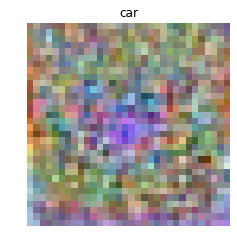

In [234]:
w = best_logistic.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 1)
w_min, w_max = np.min(w), np.max(w)
classes = ['car']
for i in range(1):
    plt.subplot(1, 2, i + 1)
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

Explain the possible reasons for the differences in the visualization of the weights in the both cases.

Generally Speaking - the weights for each class, after training should look like the class - the image should represent(on avg).
But the training mehtods are different, hence each method updates the weights in a different way.
Reasons:
1) different loss function
2) different Activation functinon

Bonus (**10 points**): Regularization is a very important technique in machine learning to prevent overfitting. Mathematically speaking, it adds a regularization term to the loss to penalize larger weights. For this part, implement L2 regularization of the form:
$$
Loss = Loss + \lambda \cdot \sum_{i=0}^k w_k^2
$$
Where $\lambda$ is yet another hyper parameter. Search for an optimal $\lambda$ (look around 5e4) and don't forget to update the gradient or the regularization won't effect the weights. When you are finished, train a perceptron classifier and visualize the weights. What do you see?

In [273]:
%%time
l2 = L2Regression(X_train, y_train)
loss_history = l2.train(X_train, y_train, 
                        learning_rate=1e-7,
                        num_iters=1500,
                        verbose=True)

plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

loss = 0.2866368671879232
grad.shape = (3073, 200)
loss = 0.2866368671879232
grad shape = (3073, 200)
W shape = (3073, 1)


ValueError: non-broadcastable output operand with shape (3073,1) doesn't match the broadcast shape (3073,200)